<a href="https://colab.research.google.com/github/SurajP00jary/Dice-Game/blob/main/aiml%20internship_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

from pathlib import Path
import os
import cv2
import glob
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
import torchvision.transforms.functional as F
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

In [ ]:
!pip install albumentations > /dev/null 2>&1


In [ ]:
!pip install pretrainedmodels > /dev/null 2>&1


In [ ]:
import albumentations
import pretrainedmodels

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/dataset/train_SOaYf6m/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/dataset/test_vc2kHdQ.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/sample_submission_yxjOnvz.csv')

In [ ]:
train_df.shape, test_df.shape

((1646, 2), (706, 1))

In [ ]:
train_df.groupby('emergency_or_not').count()

,image_names
emergency_or_not,
0,965
1,681


<Axes: xlabel='emergency_or_not', ylabel='count'>

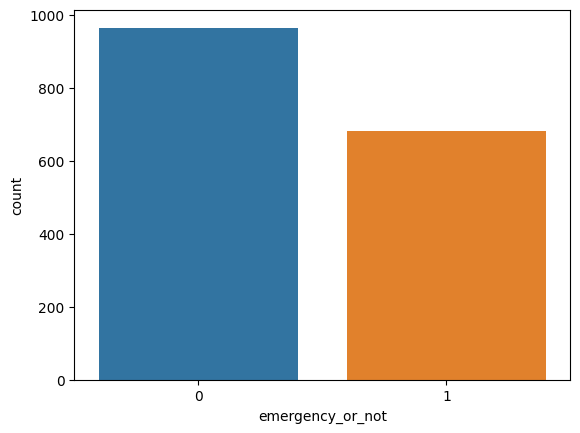

In [ ]:
sns.countplot(x='emergency_or_not' , data=train_df)

In [ ]:
## set the data folder
# data_folder = Path("../input/janatahack-av-computervision")
data_path = "/content/drive/MyDrive/dataset/train_SOaYf6m/images/"
path = os.path.join(data_path , "*jpg")

In [ ]:
data_path

'/content/drive/MyDrive/dataset/train_SOaYf6m/images/'

In [ ]:
files = glob.glob(path)
data=[]
for file in files:
    image = cv2.imread(file)
    data.append(image)

In [ ]:
train_images = data[:1646]
test_images= data[1646:]

In [ ]:
print(train_images[0].shape), print(train_images[100].shape)

(224, 224, 3)
(224, 224, 3)


(None, None)

In [ ]:
def get_images_class(cat):
    list_of_images = []
    fetch = train_df.loc[train_df['emergency_or_not']== cat][:3].reset_index()
    for i in range(0,len(fetch['image_names'])):
        list_of_images.append(fetch['image_names'][i])
    return list_of_images 

In [ ]:
get_images_class(0)

['1503.jpg', '1420.jpg', '1764.jpg']

In [ ]:
get_images_class(1)


['45.jpg', '294.jpg', '588.jpg']

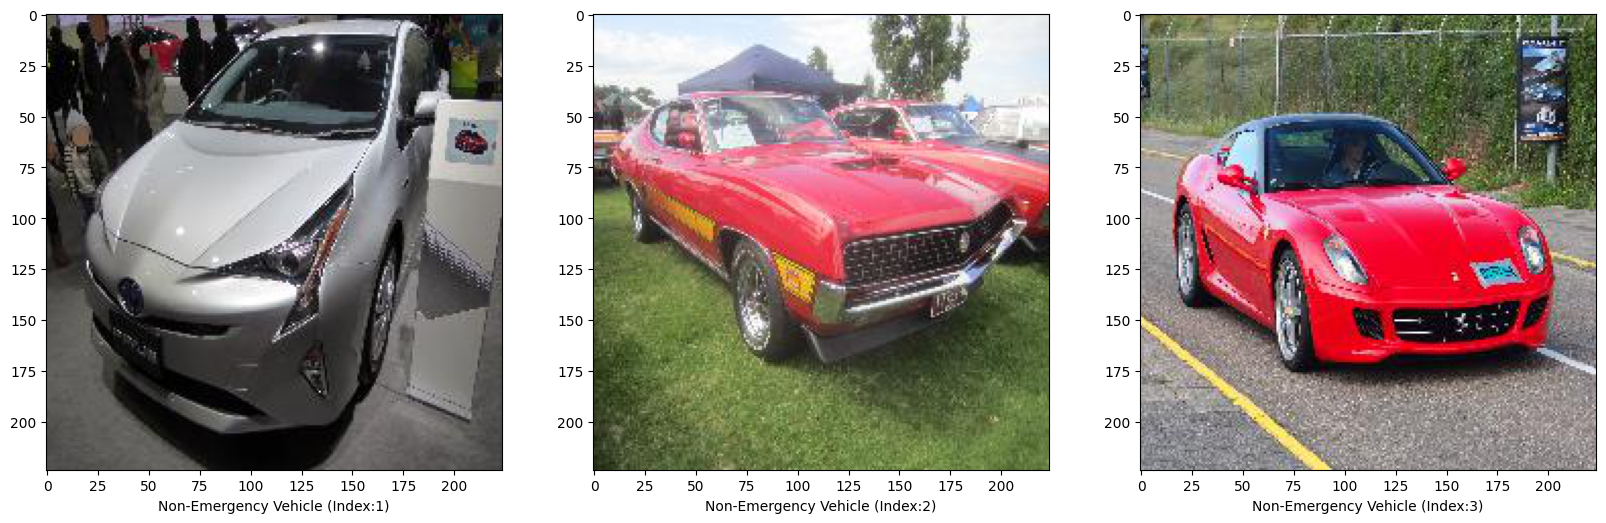

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure(figsize=(20,15))
for i, image_name in enumerate(get_images_class(0)):
    plt.subplot(1,3 ,i+1)
    img=mpimg.imread('/content/drive/MyDrive/dataset/train_SOaYf6m/images/'+image_name)
    imgplot = plt.imshow(img)
    plt.xlabel(str("Non-Emergency Vehicle") + " (Index:" +str(i+1)+")" )
plt.show()

In [ ]:
class EmergencyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image_names'], row['emergency_or_not']
        img_fname = self.root_dir + str(img_id)
#         + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [ ]:
TRAIN_CSV = '/content/drive/MyDrive/dataset/train_SOaYf6m/train.csv'
transform = transforms.Compose([transforms.ToTensor()])
dataset = EmergencyDataset(TRAIN_CSV, data_path, transform=transform)

In [ ]:
torch.manual_seed(10)
val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1317, 329)

In [ ]:
batch_size = 32

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
dataset = EmergencyDataset(TRAIN_CSV, data_path, transform=transform)

In [ ]:
train_loader  = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*4*4,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.sig = nn.Sigmoid()
    def forward(self, x):

        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))

        x = x.view(x.size(0), -1)


        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.sig(self.fc3(x))
        return x

In [ ]:
model = Net() # On CPU
#model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
n_epochs = 10
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/10], Step [0/42], Loss: 0.6777
Epoch [1/10], Step [20/42], Loss: 0.6467
Epoch [1/10], Step [40/42], Loss: 0.6111

train loss: 0.6551, train acc: 68.2612
validation loss: 0.7129, validation acc: 41.3374

Detected network improvement, saving current model
Epoch 2

Epoch [2/10], Step [0/42], Loss: 0.5999
Epoch [2/10], Step [20/42], Loss: 0.5782
Epoch [2/10], Step [40/42], Loss: 0.6314

train loss: 0.6236, train acc: 73.1967
validation loss: 0.6892, validation acc: 55.9271

Detected network improvement, saving current model
Epoch 3

Epoch [3/10], Step [0/42], Loss: 0.5386
Epoch [3/10], Step [20/42], Loss: 0.6143
Epoch [3/10], Step [40/42], Loss: 0.5091

train loss: 0.5971, train acc: 77.4487
validation loss: 0.6773, validation acc: 56.5350

Detected network improvement, saving current model
Epoch 4

Epoch [4/10], Step [0/42], Loss: 0.5013
Epoch [4/10], Step [20/42], Loss: 0.5074
Epoch [4/10], Step [40/42], Loss: 0.5619

train loss: 0.5756, train acc: 79.8785
validation lo

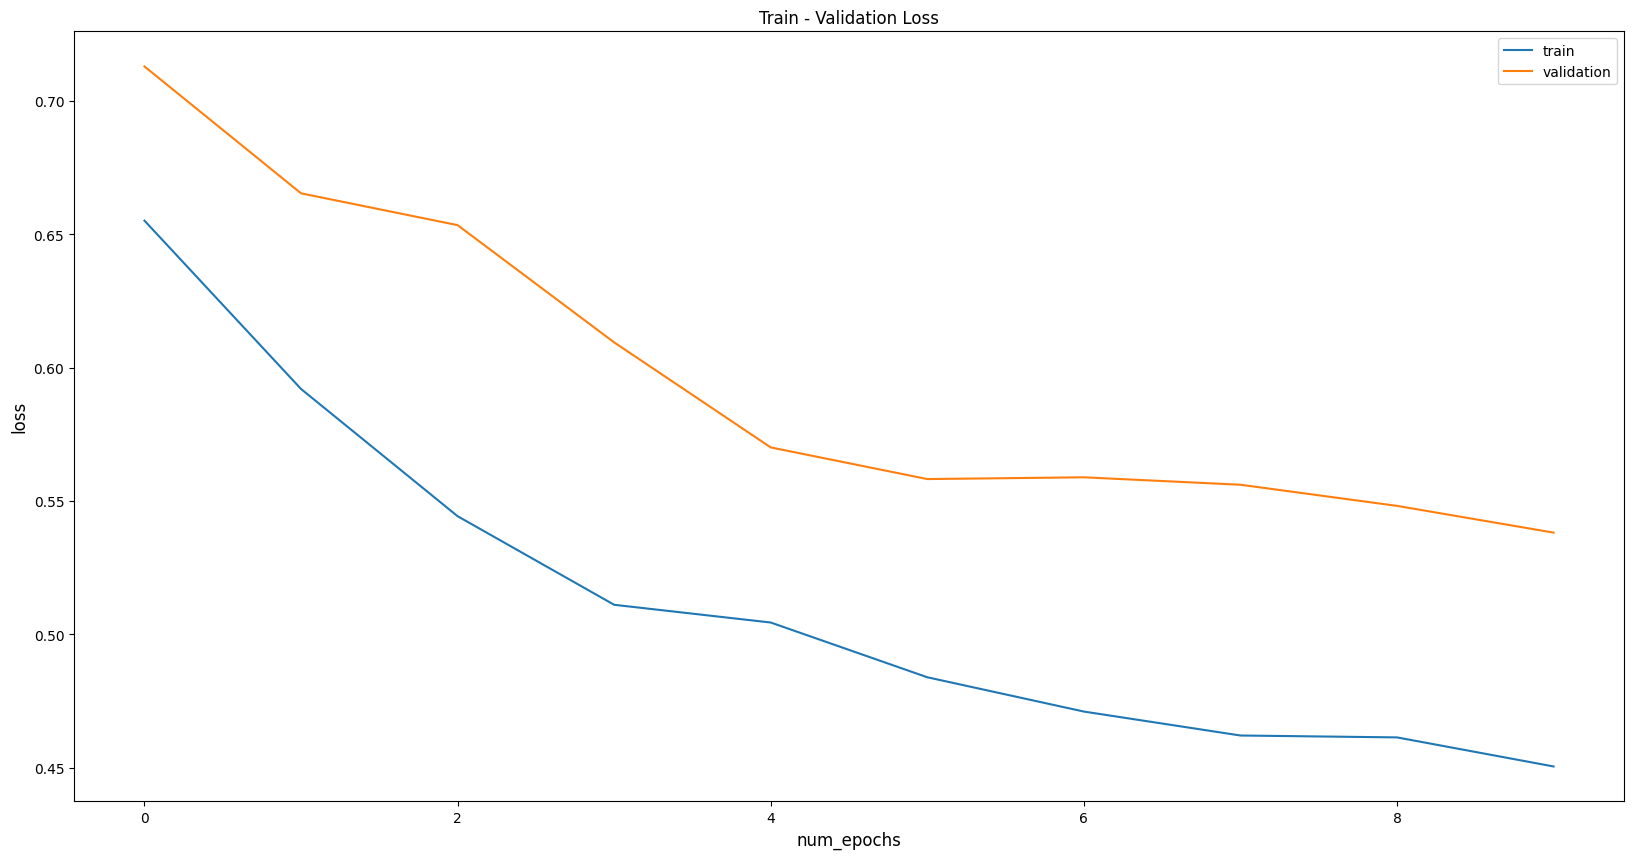

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

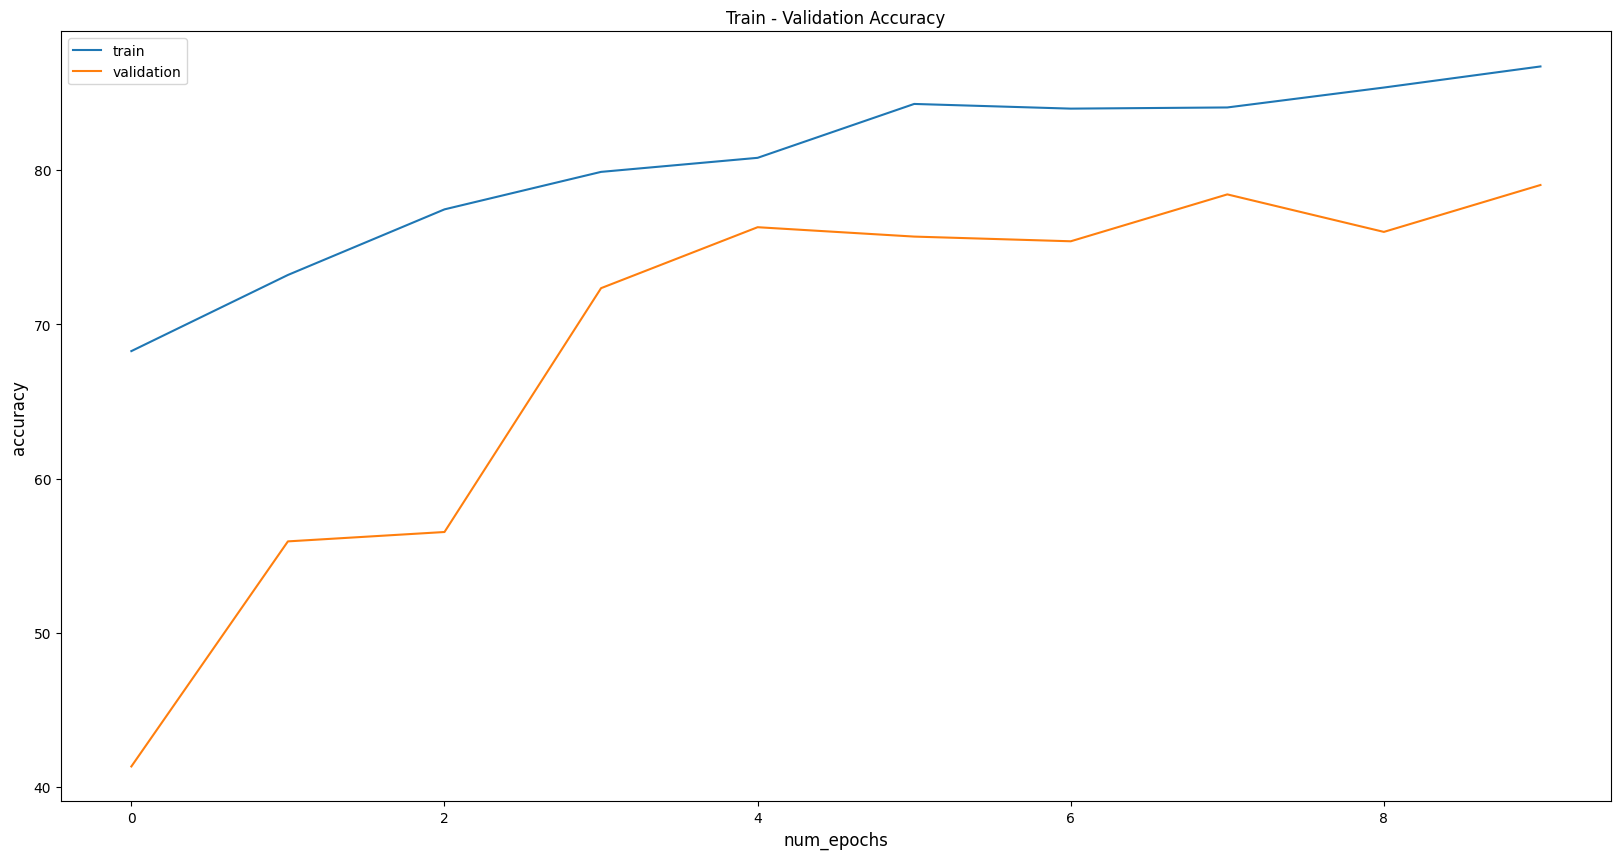

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification.pt'))

<All keys matched successfully>

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

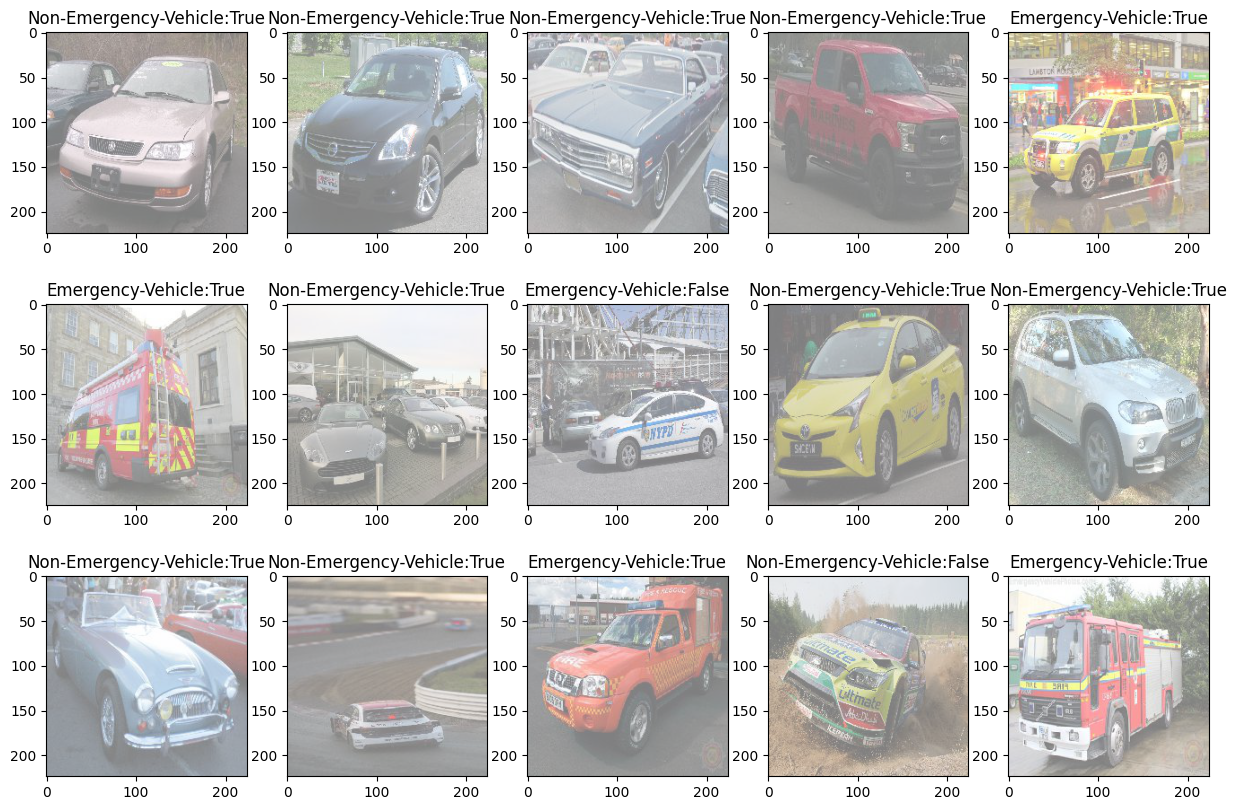

In [ ]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
vehicle_types = {0: 'Non-Emergency-Vehicle', 1: 'Emergency-Vehicle'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(vehicle_types[label.item()])+":" +str(k)) # add label

In [ ]:
TEST_CSV = '/content/drive/MyDrive/dataset/sample_submission_yxjOnvz.csv'
test_dataset = EmergencyDataset(TEST_CSV, data_path, transform=transform)

In [ ]:
len(test_dataset)


706

In [ ]:
test_dl = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)


In [ ]:
test_dl


In [ ]:
@torch.no_grad()
def predict_dl(dl, model):    
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)        
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)

    return [x.numpy() for x in batch_probs]

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
test_preds = predict_dl(test_dl, model)
submission_df.emergency_or_not = np.argmax(test_preds, axis = 1)
submission_df.head()

  0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [ ]:
submission_df.tail()


,image_names,emergency_or_not
701,674.jpg,0
702,1027.jpg,0
703,447.jpg,0
704,2176.jpg,0
705,1014.jpg,0


In [ ]:
submission_df['emergency_or_not'].value_counts()


0    698
1      8
Name: emergency_or_not, dtype: int64

In [ ]:
submission_df.to_csv('submission.csv', index=False)


In [ ]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_dl):
#     data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
submission_df['emergency_or_not'] = submission_df['emergency_or_not'].apply(lambda x: 1 if x >= 0.5 else 0)
submission_df.to_csv('submission_output.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
submission_df.head()


,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [ ]:
submission_df['emergency_or_not'].value_counts()


0    698
1      8
Name: emergency_or_not, dtype: int64

In [ ]:
print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')

validation loss: 0.5971, validation acc: 79.0274

